### Visualize PLC data in a cycle

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
from sklearn.neural_network import MLPClassifier, MLPRegressor, BernoulliRBM
import time
import datetime

#### 1. Load data and set configs.

In [4]:
# df = pd.read_table('moment_limiter.sample.TXT', delimiter='|')

# Luffing
luffing_start_end = ('Luffing-Safe brake', True, False)
travel_start_end = ('Traveling-Zero position', True, False)
slewing_start_end = ('Slewing-Motor fan', True, False)
hoisting_start_end = ('Hoist-Work brake', True, False)
df = pd.read_csv('plc.csv')
df.head()

,crane_id,opc_node_id,timestamp,value
0,P1,Overall-Fault reset,2020-12-15T02:21:33.983Z,False
1,P1,Overall-Normal / Special,2020-12-15T02:21:33.984Z,False
2,P1,Luffing-Deceleration limit for decreasing ampl...,2020-12-15T02:21:33.985Z,True
3,P1,Luffing-Decreasing amplitude limit,2020-12-15T02:21:33.986Z,True
4,P1,Luffing-Braking unit fault,2020-12-15T02:21:33.988Z,False


#### 2. Extract cycles, remove extra ends, and plot.

In [35]:
# plot settings
xmax = 200
ymax = 1000
num_bins = int(xmax/10)

df_luffing = df.loc[(df['opc_node_id'] == luffing_start_end[0])]# & (df['value'] == luffing_start_end[2])]
num_cycles = 0 #len(df_luffing.index)
starts = []
ends = []
for idx, row in df_luffing.iterrows():
    if row['value'] == True:
        starts.append([idx, row['timestamp']])
    else:
        ends.append([idx, row['timestamp']])

# filter extra ends
def get_e(s, ends):
    for idx, e in enumerate(ends):
        if e[0] > s :
            return e, ends[idx:]
start_end_pairs = []
new_ends = ends
for s in starts:
    _s = s
    _e, new_ends = get_e(_s[0], new_ends)
    start_end_pairs.append([_s, _e])
length_by_nodes = []
for s_e in start_end_pairs:
    length_by_nodes.append(s_e[1][0] - s_e[0][0])
length_by_time = []
for s_e in start_end_pairs:
    time_end = datetime.datetime.strptime(s_e[1][1], "%Y-%m-%dT%H:%M:%S.%fZ").timetuple()
    _time_end = time.mktime(time_end)
    time_start = datetime.datetime.strptime(s_e[0][1], "%Y-%m-%dT%H:%M:%S.%fZ").timetuple()
    _time_start = time.mktime(time_start)
    length_by_time.append(_time_end - _time_start)

##### 2.1 Plot threshold by time.

In [36]:
threshold = 50
warnings = []
for s_e in start_end_pairs:
    time_end = datetime.datetime.strptime(s_e[1][1], "%Y-%m-%dT%H:%M:%S.%fZ").timetuple()
    _time_end = time.mktime(time_end)
    time_start = datetime.datetime.strptime(s_e[0][1], "%Y-%m-%dT%H:%M:%S.%fZ").timetuple()
    _time_start = time.mktime(time_start)
    duration = _time_end - _time_start
    if duration > threshold:
        warnings.append(s_e[1][0])
#         warnings.append([s_e[0][0], s_e[1][0]])

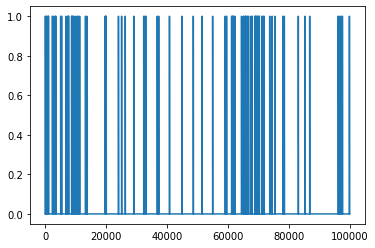

In [39]:
x = []
for i in range(100000):
    if len(x) in warnings:
        x.append(1)
    else:
        x.append(0)
plt.plot(x)
# plt.savefig('Example_50' + '.png', dpi=200)

##### 2.2 Plot Luffing cycle time.

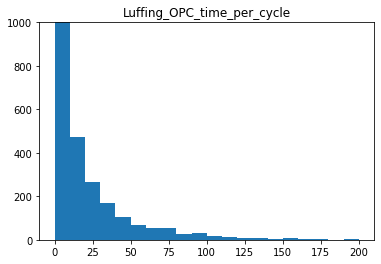

In [22]:
plt.hist(length_by_time, range=[0, xmax], bins=num_bins)
axes = plt.gca()
axes.set_ylim([0, ymax])
title_1 = 'Luffing_OPC_time_per_cycle'
plt.title(title_1)
# plt.savefig(title_1 + '.png', dpi=200)

1706 [[8, '2020-12-15T02:21:33.992Z'], [10, '2020-12-15T02:21:35.982Z']]


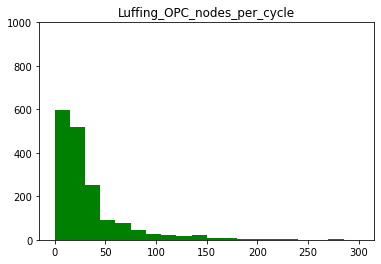

In [5]:
print(len(start_end_pairs), start_end_pairs[0])
plt.hist(length_by_nodes, range=[0, 300], color = 'g', bins=num_bins)
axes = plt.gca()
axes.set_ylim([0, ymax])
title_1 = 'Luffing_OPC_nodes_per_cycle'
plt.title(title_1)
# plt.savefig(title_1 + '.png', dpi=200)

##### 2.3 Plot Traveling cycle time.

In [6]:
# plot settings
xmax = 200
ymax = 1000
num_bins = int(xmax/10)

df_luffing = df.loc[(df['opc_node_id'] == travel_start_end[0])]# & (df['value'] == luffing_start_end[2])]
num_cycles = 0 #len(df_luffing.index)
starts = []
ends = []
for idx, row in df_luffing.iterrows():
    if row['value'] == True:
        starts.append([idx, row['timestamp']])
    else:
        ends.append([idx, row['timestamp']])

# filter extra ends
def get_e(s, ends):
    for idx, e in enumerate(ends):
        if e[0] > s:
            return e, ends[idx:]
    else:
        return [-1], []
start_end_pairs = []
new_ends = ends
for s in starts:
    _s = s
    _e, new_ends = get_e(_s[0], new_ends)
    if _e[0] != -1:
        start_end_pairs.append([_s, _e])
        
length_by_nodes = []
for s_e in start_end_pairs:
    length_by_nodes.append(s_e[1][0] - s_e[0][0])
length_by_time = []
for s_e in start_end_pairs:
    time_end = datetime.datetime.strptime(s_e[1][1], "%Y-%m-%dT%H:%M:%S.%fZ").timetuple()
    _time_end = time.mktime(time_end)
    time_start = datetime.datetime.strptime(s_e[0][1], "%Y-%m-%dT%H:%M:%S.%fZ").timetuple()
    _time_start = time.mktime(time_start)
    length_by_time.append(_time_end - _time_start)

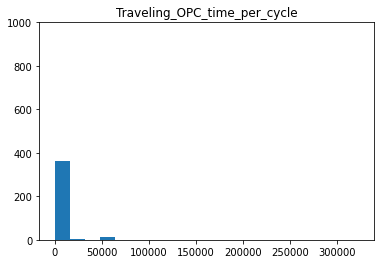

In [7]:
plt.hist(length_by_time, bins=num_bins)
axes = plt.gca()
axes.set_ylim([0, ymax])
title_1 = 'Traveling_OPC_time_per_cycle'
plt.title(title_1)
# plt.savefig(title_1 + '.png', dpi=200)

380 [[74, '2020-12-15T02:27:15.744Z'], [96, '2020-12-15T02:37:48.985Z']]


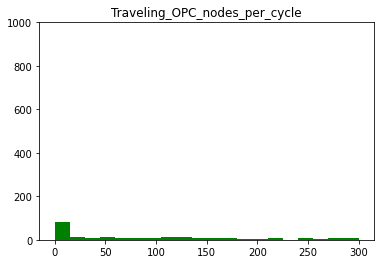

In [8]:
print(len(start_end_pairs), start_end_pairs[0])
plt.hist(length_by_nodes, range=[0, 300],  color = 'g', bins=num_bins)
axes = plt.gca()
axes.set_ylim([0, ymax])
title_1 = 'Traveling_OPC_nodes_per_cycle'
plt.title(title_1)
# plt.savefig(title_1 + '.png', dpi=200)

##### 2.4 Plot Slewing cycle time.

In [9]:
# plot settings
xmax = 200
ymax = 1000
num_bins = int(xmax/10)

df_luffing = df.loc[(df['opc_node_id'] == slewing_start_end[0])]# & (df['value'] == luffing_start_end[2])]
num_cycles = 0 #len(df_luffing.index)
starts = []
ends = []
for idx, row in df_luffing.iterrows():
    if row['value'] == True:
        starts.append([idx, row['timestamp']])
    else:
        ends.append([idx, row['timestamp']])

# filter extra ends
def get_e(s, ends):
    for idx, e in enumerate(ends):
        if e[0] > s:
            return e, ends[idx:]
    else:
        return -1, []
start_end_pairs = []
new_ends = ends
for s in starts:
    _s = s
    _e, new_ends = get_e(_s[0], new_ends)
    if _e != -1:
        start_end_pairs.append([_s, _e])

length_by_nodes = []
for s_e in start_end_pairs:
    length_by_nodes.append(s_e[1][0] - s_e[0][0])
length_by_time = []
for s_e in start_end_pairs:
    time_end = datetime.datetime.strptime(s_e[1][1], "%Y-%m-%dT%H:%M:%S.%fZ").timetuple()
    _time_end = time.mktime(time_end)
    time_start = datetime.datetime.strptime(s_e[0][1], "%Y-%m-%dT%H:%M:%S.%fZ").timetuple()
    _time_start = time.mktime(time_start)
    length_by_time.append(_time_end - _time_start)

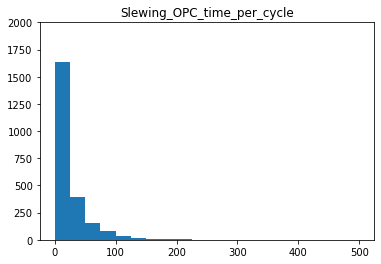

In [20]:
plt.hist(length_by_time, range=[0, 500], bins=num_bins)
axes = plt.gca()
axes.set_ylim([0, ymax+1000])
title_1 = 'Slewing_OPC_time_per_cycle'
plt.title(title_1)
# plt.savefig(title_1 + '.png', dpi=200)

2339 [[169, '2020-12-15T02:39:01.734Z'], [185, '2020-12-15T02:39:17.983Z']]


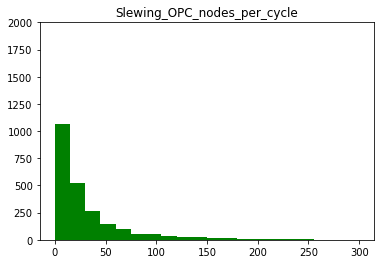

In [21]:
print(len(start_end_pairs), start_end_pairs[0])
plt.hist(length_by_nodes, range=[0, 300], color = 'g', bins=num_bins)
axes = plt.gca()
axes.set_ylim([0, ymax*2])
title_1 = 'Slewing_OPC_nodes_per_cycle'
plt.title(title_1)
# plt.savefig(title_1 + '.png', dpi=200)

##### 2.5 Plot Hoisting cycle time.

In [12]:
# plot settings
xmax = 200
ymax = 1000
num_bins = int(xmax/10)

df_luffing = df.loc[(df['opc_node_id'] == hoisting_start_end[0])]# & (df['value'] == luffing_start_end[2])]
num_cycles = 0 #len(df_luffing.index)
starts = []
ends = []
for idx, row in df_luffing.iterrows():
    if row['value'] == True:
        starts.append([idx, row['timestamp']])
    else:
        ends.append([idx, row['timestamp']])

# filter extra ends
def get_e(s, ends):
    for idx, e in enumerate(ends):
        if e[0] > s:
            return e, ends[idx:]
    else:
        return -1, []
start_end_pairs = []
new_ends = ends
for s in starts:
    _s = s
    _e, new_ends = get_e(_s[0], new_ends)
    if _e != -1:
        start_end_pairs.append([_s, _e])

length_by_nodes = []
for s_e in start_end_pairs:
    length_by_nodes.append(s_e[1][0] - s_e[0][0])
length_by_time = []
for s_e in start_end_pairs:
    time_end = datetime.datetime.strptime(s_e[1][1], "%Y-%m-%dT%H:%M:%S.%fZ").timetuple()
    _time_end = time.mktime(time_end)
    time_start = datetime.datetime.strptime(s_e[0][1], "%Y-%m-%dT%H:%M:%S.%fZ").timetuple()
    _time_start = time.mktime(time_start)
    length_by_time.append(_time_end - _time_start)

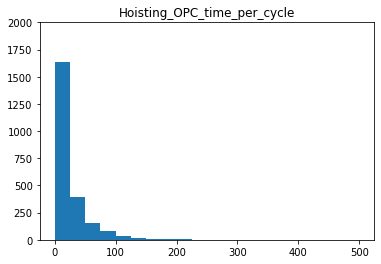

In [13]:
plt.hist(length_by_time, range=[0, 500], bins=num_bins)
axes = plt.gca()
axes.set_ylim([0, ymax+1000])
title_1 = 'Hoisting_OPC_time_per_cycle'
plt.title(title_1)
# plt.savefig(title_1 + '.png', dpi=200)

2339 [[169, '2020-12-15T02:39:01.734Z'], [185, '2020-12-15T02:39:17.983Z']]


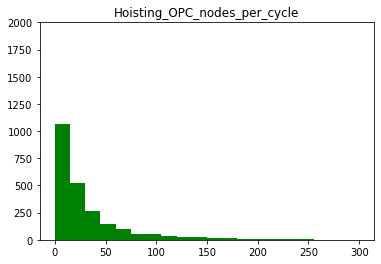

In [14]:
print(len(start_end_pairs), start_end_pairs[0])
plt.hist(length_by_nodes, range=[0, 300], color = 'g', bins=num_bins)
axes = plt.gca()
axes.set_ylim([0, ymax*2])
title_1 = 'Hoisting_OPC_nodes_per_cycle'
plt.title(title_1)
# plt.savefig(title_1 + '.png', dpi=200)